# <center>Bonus Problem</center>
## <center>Backprop Fails to Separate where Perceptron Succeeds</center>
### Authors
#### Ibrahim Alzekri 201616860
#### Abdullah Alkhalifah 201690090
In this notebook we will proof that in some cases, backpropagation fails to seperate all points. Whereas a single perceptron succeeds to sepearate the points perfectly


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

print(torch.__version__)

1.6.0


### i. Sampling
Here, we are going to generate n random points with a shape similar to the following dataset

<img src="backFailsDist.png" style="max-width: 300px;" />


Then, we will add some noise that our perceptron will be able to seperate, while the backpropagation will fail.

In [2]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes

    set_size = int(n/3)
    #Set 1
    x1_a = np.random.uniform(low= 2 , high= 3, size= set_size).reshape(-1,1)
    x2_a = np.random.uniform(low= -0.3 , high= 0.3, size= set_size).reshape(-1,1)
    x = np.concatenate([x1_a,x2_a],axis=1)
    
    #set 2
    x1_b = np.random.uniform(low= -0.3 , high= 0.3, size= set_size).reshape(-1,1)
    x2_b = np.random.uniform(low= 2 , high= 3, size= set_size).reshape(-1,1)
    x = np.append(x, np.concatenate([x1_b,x2_b],axis=1), axis=0 ) 
    
    #set 3
    x1_c = np.random.uniform(low= -3 , high= -2, size= set_size).reshape(-1,1)
    x2_c = np.random.uniform(low= -0.3 , high= 0.3, size= set_size).reshape(-1,1)
    x = np.append(x, np.concatenate([x1_c,x2_c],axis=1), axis=0 ) 

    y = np.zeros( (1, 2*set_size) )
    y = np.append(y, np.ones((1, set_size)) )

    #noise
    n_size = int(n/30)
    x1_n = np.random.uniform(low= -1 , high= -0.8, size= n_size).reshape(-1,1)
    x2_n = np.random.uniform(low= -1 , high= -0.8, size= n_size).reshape(-1,1)
    x = np.append(x, np.concatenate([x1_n,x2_n],axis=1), axis=0 ) 
    y = np.append(y, np.zeros((1, n_size)) )
    
    return x,y

### ii. Designing a Single Perceptron with defined parameters
Here is our single perceptron with parameters: w1 = -2.5, w2 = -1, b = -4. And a simple step functon as activation function

In [3]:
class perceptron(nn.Module):

    def __init__(self):
        super().__init__()

        # initialize layers
        self.layer1 = nn.Linear(2, 1)
        self.intialize_params()


    def forward(self, x):

        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        output = self.step(self.layer1(x))

        return output
    
    def intialize_params(self):        
        
        
        old_params = {}

        for name, params in self.named_parameters():
            old_params[name] = params.clone()


        old_params['layer1.weight'] = [-2.5 , -1]                
        old_params['layer1.bias'] = [-4]


        for name, params in self.named_parameters():
            params.data.copy_(torch.tensor(old_params[name]))


    def step (self, x):
        return (x>=0)*1

### iii. Designing a Single Perceptron with backpropagation implementation
Here is our backpropagation model. Which is a single perceptron with backpropagation implementation and ReLU as an activation function

In [4]:
class backpropagation(nn.Module):
    

  def __init__(self): 
    super().__init__()
    self.layer1 = nn.Linear(2,2)
    self.act = nn.ReLU()


  def forward(self,x):
    x = self.layer1(x)
    return self.act(x)
    
  def train_net(self,x,y,n_iters):

    train_data = x
    train_labels = y

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(self.parameters(),lr=0.01)

    for epoch in range(n_iters):
      #zero the gradients
      optimizer.zero_grad()

      #compute foward, backward and optimize
      output = self(train_data)
      loss = criterion(output,train_labels)
      loss.backward()
      optimizer.step()
      if epoch%100==99: # every 500 iterations, print statistics
          print("epoch #: ",epoch+1)
          # accuracy of the train prediction
          train_prediction = output.cpu().detach().argmax(dim=1)
          train_accuracy = (train_prediction.numpy()==train_labels.cpu().detach().numpy()).mean()

          print("Training loss :",loss.cpu().detach().numpy())
          print("Training accuracy :",train_accuracy)
          print('='*20)

### iv. Plotting
Thie method is to plot the dataset with two seperators. One found by the single perceptron model, and the other produced by the backpropagation model

In [5]:
def compare_models(net1, net2, x, y):

# Getting true and false points
  green = x.numpy()[np.where(y==1)[0]]
  red = x.numpy()[np.where(y==0)[0]]

# Getting models weights and biasses to draw seperator lines
  model1_params = {}
  
  for name, params in net1.named_parameters():
      model1_params[name] = params.clone()

  model2_params = {}
  
  for name, params in net2.named_parameters():
      model2_params[name] = params.clone()

  m1_w = model1_params['layer1.weight'][0].detach().numpy()
  m1_b = model1_params['layer1.bias'][0].detach().numpy()

  m2_w = model2_params['layer1.weight'][0].detach().numpy()
  m2_b = model2_params['layer1.bias'][0].detach().numpy()

  fig, ax = plt.subplots()

  plt.xlim((-5,5))
  plt.ylim((-5,5))

  # Slope and bias of the function
  m = -(m1_w[0]/m1_w[1])
  b = -(m1_b/m1_w[1])
  plt.plot(x, m*x + b , linestyle='-', color='b')  # solid

  m = -(m2_w[0]/m2_w[1])
  b = -(m2_b/m2_w[1])
  plt.plot(x, m*x + b, linestyle='--',  color='r') # dashed

  pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
  neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

  ax.add_artist(pos_values)
  ax.add_artist(neg_values)

### v. Creating and training models
We will creaete sample points with n = 30, similar to the shape proposed in the begining. Then, we will create the two models and train the backpropagation model

In [6]:
x, y = sample_points(30)
x = torch.from_numpy(x).float() # data points
y = torch.from_numpy(y).long() # labels

perceptron_model = perceptron()
backpro_model = backpropagation()
backpro_model.train_net(x,y,500)

epoch #:  100
Training loss : 0.23891088
Training accuracy : 1.0
epoch #:  200
Training loss : 0.17585386
Training accuracy : 0.967741935483871
epoch #:  300
Training loss : 0.14220333
Training accuracy : 0.967741935483871
epoch #:  400
Training loss : 0.121664345
Training accuracy : 0.967741935483871
epoch #:  500
Training loss : 0.10806042
Training accuracy : 0.967741935483871


### vi. Printing Models and Seperators
The **blue** line is produced by the **single perceptron** model. And the **red** line is produced by the **backprooagation** model

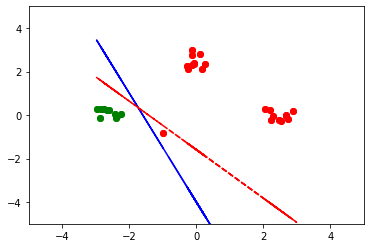

In [7]:
compare_models(perceptron_model, backpro_model, x, y)

### vii. Results
As we can see, though the backpropagation model has converged. It still fails to seperate all points correctly. On the other hand, the single perceptron model succeeded to seperate all points correctly